In [168]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import numpy as np
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [169]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [170]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [181]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        lr_decay = config["learning_rate_decay"]
        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
            
        if lr_decay != None:
            self.lr_decay = lr_decay
        
        self.task = task
        self.model = nn.Sequential()
        
        units = config["units_1"]
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(1, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            self.apply(self.init_weights_uniform)
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            self.apply(self.init_weights_normal)
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [177]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_test.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=5, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
            
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                        
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    
    y_pred = model(torch.from_numpy(x_test).to(torch.float32))
    y_test = torch.from_numpy(y_test).to(torch.float32)
    
    acc = model.compute_metric(y_pred, y_test)
    loss = model.compute_loss(y_pred, y_test)
    
    print(f"Test MSE: {loss}")
    print(f"Test accuracy: {acc}")
    
    #test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)
    #trainer.test(model=model, dataloaders=test_loader)
    #input_size = x_test.shape[1]
    #result = model.evaluate(x_test, y_test)
    #print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model(torch.from_numpy(x_train).to(torch.float32))
    y_test_pred = model(torch.from_numpy(x_test).to(torch.float32))
    
    if scale:
        
        y_train_pred = y_train_pred.detach().numpy()
        y_test_pred = y_test_pred.detach().numpy()
        
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)
        
        y_train_pred  = torch.from_numpy(y_train_pred).to(torch.float32)
        y_test_pred  = torch.from_numpy(y_test_pred).to(torch.float32)
        
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)
    

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
        
    return model

# Monk 1

In [111]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [39]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 50,
        "delta": 0.0001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 50, 'delta': 0.0001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.33s/it]


Median val_loss: 0.0053205026783963, std val_loss 0.04606737499886979
Median train_loss: 0.0002004237030632, std train_loss 0.03884974447775888
Median val_accuracy: 1.0, std val_accuracy 0.0815364805642081
Median train_accuracy: 1.0, train_accuracy 0.04571428298950195






Best configuration (loss 0.0053205026783963):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 50, 'delta': 0.0001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 16}


 10%|████▍                                       | 1/10 [00:06<00:59,  6.60s/it]

Trial 1/10 val_mse: 0.0003862969650541
Trial 1/10 train_mse: 0.0002943720319308
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:12<00:51,  6.39s/it]

Trial 2/10 val_mse: 0.0004241452892677
Trial 2/10 train_mse: 0.0002466004516463
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:21<00:51,  7.36s/it]

Trial 3/10 val_mse: 0.0004883829074856
Trial 3/10 train_mse: 0.0002296600141562
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:31<00:49,  8.33s/it]

Trial 4/10 val_mse: 0.0007136947134654
Trial 4/10 train_mse: 0.0002459957904648
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:32<00:29,  5.84s/it]

Trial 5/10 val_mse: 0.080187461471741
Trial 5/10 train_mse: 0.0953601971268653
Trial 5/10 val_accuracy: 0.8399999737739563
Trial 5/10 train_accuracy: 0.8888888955116272


 60%|██████████████████████████▍                 | 6/10 [00:40<00:25,  6.50s/it]

Trial 6/10 val_mse: 0.0003052119973129
Trial 6/10 train_mse: 0.0003091286926064
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:49<00:22,  7.36s/it]

Trial 7/10 val_mse: 0.0006423563063663
Trial 7/10 train_mse: 0.0002384101826464
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [00:59<00:16,  8.06s/it]

Trial 8/10 val_mse: 0.0007817062331588
Trial 8/10 train_mse: 0.0002306332462467
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:06<00:07,  7.76s/it]

Trial 9/10 val_mse: 0.0004879404407934
Trial 9/10 train_mse: 0.000258898595348
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:15<00:00,  7.54s/it]

Trial 10/10 val_mse: 0.0010392574694199
Trial 10/10 train_mse: 0.0002962306898552
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.0006423563063663, std val_mse: 0.023881499979985128
Median train_mse: 0.0002384101826464, std train_mse: 0.028529741332180617
Median val_accuracy: 1.0, std val_accuracy: 0.04800000786781311
Median train_accuracy: 1.0, std train_accuracy: 0.03333333134651184


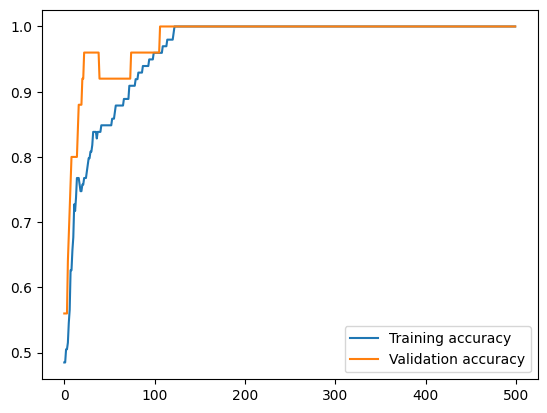

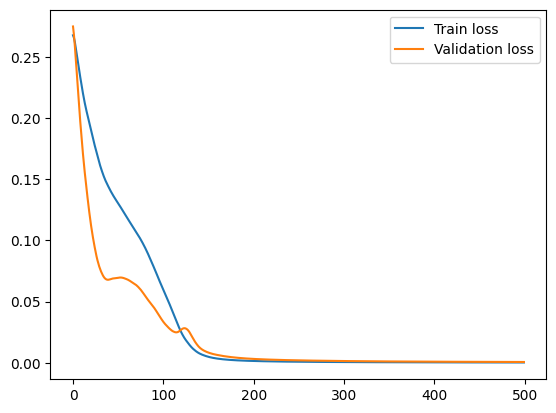

Test MSE: 0.004782378673553467
Test accuracy: 1.0


In [40]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

# Monk 2

In [68]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [49]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 50,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 50, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.00s/it]


Median val_loss: 0.0611773932219697, std val_loss 0.04431247187029399
Median train_loss: 0.0398092530667781, std train_loss 0.03742408021341591
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.05156820549543873
Median train_accuracy: 0.961904764175415, train_accuracy 0.044426297503188446






Best configuration (loss 0.0611773932219697):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 50, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


 10%|████▍                                       | 1/10 [00:07<01:11,  7.95s/it]

Trial 1/10 val_mse: 0.0802973648082816
Trial 1/10 train_mse: 0.060836911201477
Trial 1/10 val_accuracy: 0.9200000166893004
Trial 1/10 train_accuracy: 0.939393937587738


 20%|████████▊                                   | 2/10 [00:15<01:02,  7.82s/it]

Trial 2/10 val_mse: 0.0034161302994804
Trial 2/10 train_mse: 0.0019850949756801
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:19<00:42,  6.02s/it]

Trial 3/10 val_mse: 0.0900735848484183
Trial 3/10 train_mse: 0.1094843745231628
Trial 3/10 val_accuracy: 0.9200000166893004
Trial 3/10 train_accuracy: 0.868686854839325


 40%|█████████████████▌                          | 4/10 [00:27<00:40,  6.72s/it]

Trial 4/10 val_mse: 0.0802796967236363
Trial 4/10 train_mse: 0.0608550906181335
Trial 4/10 val_accuracy: 0.9200000166893004
Trial 4/10 train_accuracy: 0.939393937587738


 50%|██████████████████████                      | 5/10 [00:35<00:35,  7.08s/it]

Trial 5/10 val_mse: 0.0005035341294481
Trial 5/10 train_mse: 0.0509329065680503
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 0.9494949579238892


 60%|██████████████████████████▍                 | 6/10 [00:43<00:29,  7.42s/it]

Trial 6/10 val_mse: 0.0018138482398553
Trial 6/10 train_mse: 0.0012425819877535
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:50<00:22,  7.49s/it]

Trial 7/10 val_mse: 0.001091148331059
Trial 7/10 train_mse: 0.0003480747982393
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [00:58<00:15,  7.56s/it]

Trial 8/10 val_mse: 0.0065698528097323
Trial 8/10 train_mse: 0.0005243996856734
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:00<00:05,  5.93s/it]

Trial 9/10 val_mse: 0.1159151721798123
Trial 9/10 train_mse: 0.093667633831501
Trial 9/10 val_accuracy: 0.8799999952316284
Trial 9/10 train_accuracy: 0.868686854839325


100%|███████████████████████████████████████████| 10/10 [01:04<00:00,  6.41s/it]

Trial 10/10 val_mse: 0.1077133652981959
Trial 10/10 train_mse: 0.0962397828698158
Trial 10/10 val_accuracy: 0.8799999952316284
Trial 10/10 train_accuracy: 0.9191918969154358

Median val_mse: 0.0802796967236363, std val_mse: 0.04724536692964526
Median train_mse: 0.0608550906181335, std train_mse: 0.041663338399810346
Median val_accuracy: 0.9200000166893004, std val_accuracy: 0.0499599821546666
Median train_accuracy: 0.939393937587738, std train_accuracy: 0.04937111460846624


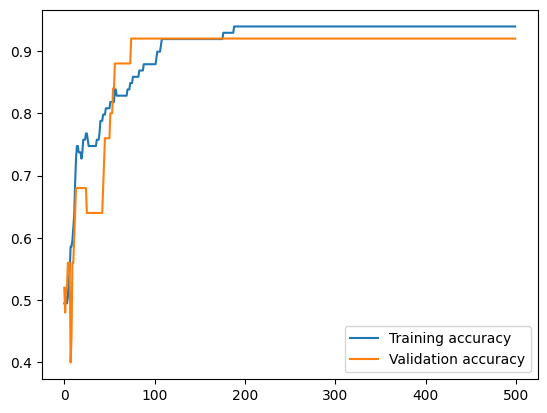

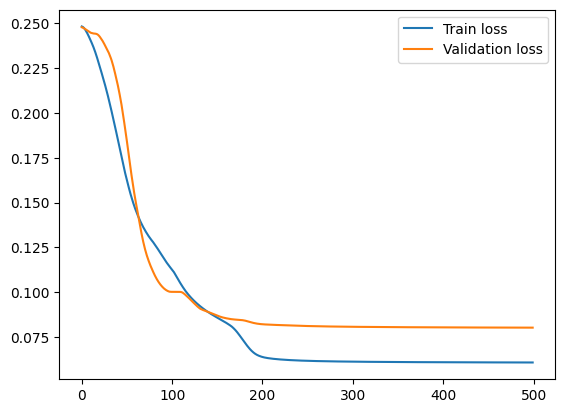

Test MSE: 0.08386094123125076
Test accuracy: 0.9166666865348816


In [50]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

# Monk 3

In [178]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


In [179]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 100,
        "delta": 0
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": {
        "lr_final": 0.001,
        "epochs": 100
    },
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 100, 'delta': 0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'lr_final': 0.001, 'epochs': 100}, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.044559999999999995
0.04357000000000001
0.04258000000000001
0.04159000000000001
0.04060000000000001
0.039610000000000006
0.03862000000000001
0.03763
0.03664
0.035649999999999994
0.

 20%|█████████                                    | 1/5 [00:03<00:13,  3.26s/it]

0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.044559999999999995
0.04357000000000001
0.04258000000000001
0.04159000000000001
0.04060000000000001
0.039610000000000006
0.03862000000000001
0.03763
0.03664
0.035649999999999994
0.

 40%|██████████████████                           | 2/5 [00:14<00:24,  8.15s/it]

0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.044559999999999995
0.04357000000000001
0.04258000000000001
0.04159000000000001
0.04060000000000001
0.039610000000000006
0.03862000000000001
0.03763
0.03664
0.035649999999999994
0.

 60%|███████████████████████████                  | 3/5 [00:17<00:11,  5.82s/it]

0.001
0.001
0.001
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.044559999999999995
0.04357000000000001
0.04258000000000001
0.04159000000000001
0.04060000000000001
0.039610000000000006
0.03862000000000001
0.03763
0.03664
0.035

 80%|████████████████████████████████████         | 4/5 [00:21<00:04,  4.80s/it]

0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.044559999999999995
0.04357000000000001
0.04258000000000001
0.04159000000000001
0.04060000000000001
0.039610000000000006
0.03862000000000001
0.03763
0.03664
0.035649999999999994
0.

100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.79s/it]


0.001
0.001
Median val_loss: 0.0456035645069936, std val_loss 0.009285863046529515
Median train_loss: 0.0598269924521446, std train_loss 0.005052062979060039
Median val_accuracy: 0.9200000166893004, std val_accuracy 0.04664761360500293
Median train_accuracy: 0.938144326210022, train_accuracy 0.010513442922717655






Best configuration (loss 0.0456035645069936):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 100, 'delta': 0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'lr_final': 0.001, 'epochs': 100}, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.044559999999999995
0.04357000000000001
0.04258000000000001
0.04159000000000001
0.04060000000000001
0.039610000000000006
0.03862000000000001
0.03763
0.03664
0.035649999999999994
0.

 10%|████▍                                       | 1/10 [00:03<00:28,  3.12s/it]

Trial 1/10 val_mse: 0.0469777554848594
Trial 1/10 train_mse: 0.0508008450269699
Trial 1/10 val_accuracy: 0.959999978542328
Trial 1/10 train_accuracy: 0.938144326210022
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0.04455999999

 20%|████████▊                                   | 2/10 [00:14<01:02,  7.86s/it]

0.001
0.001
0.001
0.001
0.001
Trial 2/10 val_mse: 0.0457227187595391
Trial 2/10 train_mse: 0.0570216998457908
Trial 2/10 val_accuracy: 0.959999978542328
Trial 2/10 train_accuracy: 0.9278350472450256
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.0475

 30%|█████████████▏                              | 3/10 [00:17<00:38,  5.54s/it]

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
Trial 3/10 val_mse: 0.0492941112717042
Trial 3/10 train_mse: 0.0536830238997936
Trial 3/10 val_accuracy: 0.959999978542328
Trial 3/10 train_accuracy: 0.9484536051750184
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149

 40%|█████████████████▌                          | 4/10 [00:21<00:30,  5.13s/it]

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
Trial 4/10 val_mse: 0.0484725961522916
Trial 4/10 train_mse: 0.0592900402843952
Trial 4/10 val_accuracy: 0.959999978542328
Trial 4/10 train_accuracy: 0.9278350472450256
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149

 50%|██████████████████████                      | 5/10 [00:25<00:22,  4.54s/it]

0.001
0.001
0.001
0.001
0.001
0.001
Trial 5/10 val_mse: 0.0494821066879869
Trial 5/10 train_mse: 0.0586013905704021
Trial 5/10 val_accuracy: 0.959999978542328
Trial 5/10 train_accuracy: 0.9278350472450256
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852


 60%|██████████████████████████▍                 | 6/10 [00:37<00:28,  7.19s/it]

0.001
0.001
Trial 6/10 val_mse: 0.0497571553522021
Trial 6/10 train_mse: 0.0504496842622756
Trial 6/10 val_accuracy: 0.959999978542328
Trial 6/10 train_accuracy: 0.938144326210022
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.04654
0.04555
0

 70%|██████████████████████████████▊             | 7/10 [00:40<00:17,  5.95s/it]

0.001
0.001
0.001
0.001
Trial 7/10 val_mse: 0.0479959150103813
Trial 7/10 train_mse: 0.0507155805826187
Trial 7/10 val_accuracy: 0.959999978542328
Trial 7/10 train_accuracy: 0.938144326210022
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.046

 80%|███████████████████████████████████▏        | 8/10 [00:43<00:10,  5.00s/it]

0.001
0.001
0.001
0.001
Trial 8/10 val_mse: 0.0451606047396389
Trial 8/10 train_mse: 0.0530298873782157
Trial 8/10 val_accuracy: 0.959999978542328
Trial 8/10 train_accuracy: 0.938144326210022
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.0505
0.04951
0.04852
0.04753
0.046

 90%|███████████████████████████████████████▌    | 9/10 [00:46<00:04,  4.34s/it]

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
Trial 9/10 val_mse: 0.0487390152357389
Trial 9/10 train_mse: 0.0502975583076477
Trial 9/10 val_accuracy: 0.959999978542328
Trial 9/10 train_accuracy: 0.9484536051750184
0.1
0.09901
0.09802000000000001
0.09703
0.09604
0.09505
0.09406
0.09307
0.09208000000000001
0.09109000000000002
0.09010000000000001
0.08911000000000001
0.08812
0.08713000000000001
0.08614000000000001
0.08515
0.08416
0.08317000000000001
0.08218000000000002
0.08119000000000001
0.08020000000000002
0.07921000000000002
0.07822000000000001
0.07723000000000001
0.07624000000000002
0.07525000000000001
0.07425999999999999
0.07327
0.07228
0.07128999999999999
0.07029999999999999
0.06931
0.06831999999999999
0.06732999999999999
0.06633999999999998
0.06535
0.06436
0.06337
0.06238
0.06139
0.060399999999999995
0.05941000000000001
0.05842000000000001
0.05743000000000001
0.05644000000000001
0.055450000000000006
0.05446000000000001
0.053470000000000004
0.052480000000000006
0.05149
0.050

100%|███████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]

0.001
Trial 10/10 val_mse: 0.049607144075721
Trial 10/10 train_mse: 0.0584077164530754
Trial 10/10 val_accuracy: 0.959999978542328
Trial 10/10 train_accuracy: 0.938144326210022

Median val_mse: 0.0487390152357389, std val_mse: 0.0015639162353886752
Median train_mse: 0.0502975583076477, std train_mse: 0.0035435088668984457
Median val_accuracy: 0.959999978542328, std val_accuracy: 1.1102230246251565e-16
Median train_accuracy: 0.9484536051750184, std train_accuracy: 0.007216495275497472


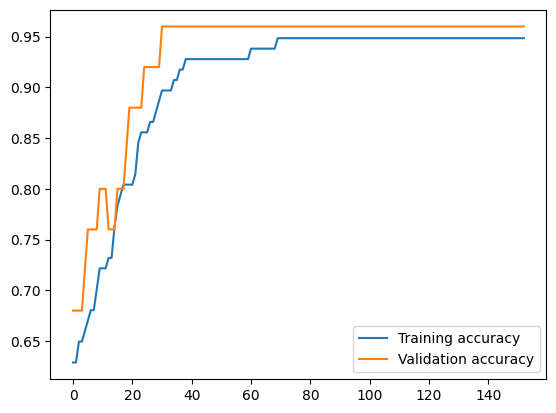

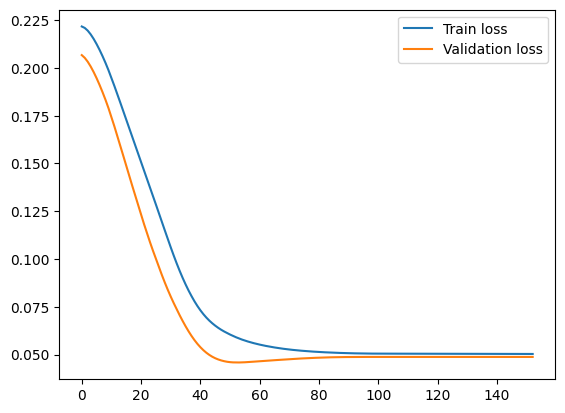

Test MSE: 0.043257586658000946
Test accuracy: 0.9606481194496155


In [180]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

# ML Cup

In [98]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print(x_test_blind.shape)

(1343, 9) (1343, 2)
(149, 9) (149, 2)


In [101]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 5,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.3],
    "batch_size": [32],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.001
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [10],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [102]:
model = grid_search(params, x_train, y_train, hold_out_val)
assess_model(model, x_train, y_train, x_test, y_test, True)

Testing configuration 1/1:
{'batch_size': 32, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.001}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 10}


  0%|                                                     | 0/5 [00:00<?, ?it/s]


IndexError: list index out of range